# Portfolio Optimization: Traditional vs Crypto Assets

This notebook implements three portfolio optimization methods for both traditional and crypto asset universes:

1. **Mean-Variance Optimization (MVO/Tangency Portfolio)**
2. **Risk Parity**
3. **CVaR-Constrained Optimization**

Each method is applied separately to traditional and crypto assets, resulting in 6 portfolios total.


## 1. Setup & Data Loading


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add cmds to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'cmds'))
import portfolio_management_helper as pmh

# Constants
MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

ANNUAL_FACTOR = 252  # Daily data

# Asset universes
TRAD_ASSETS = [
    "^SPX", "^RUT", "URTH",
    "AGG", "IEF", "TLT",
    "VNQ",
    "GLD", "DBC",
    "PUT", "^VIX",
    "^IRX",
    "CDX.NA.IG"
]
CRYPTO_ASSETS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "SHIB-USD", "DOGE-USD"]

# Create output directories
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

print("Setup complete.")


Setup complete.


In [2]:
# Load data
prices = pd.read_csv(MASTER_CSV, index_col=0, parse_dates=True)
prices.index = pd.to_datetime(prices.index)

# Extract risk-free rate (RF is in percent, convert to decimal)
rf_daily = prices['RF'] / 100

# Calculate simple returns
returns_all = prices.pct_change().dropna()

# Filter to available assets
trad_available = [a for a in TRAD_ASSETS if a in returns_all.columns]
crypto_available = [a for a in CRYPTO_ASSETS if a in returns_all.columns]

print(f"Traditional assets available: {trad_available}")
print(f"Crypto assets available: {crypto_available}")

# Extract returns for each universe
returns_trad = returns_all[trad_available].copy()
returns_crypto = returns_all[crypto_available].copy()

# Align RF to returns index
rf_daily = rf_daily.loc[returns_all.index]

# Compute excess returns
excess_returns_trad = returns_trad.sub(rf_daily, axis=0)
excess_returns_crypto = returns_crypto.sub(rf_daily, axis=0)

# Drop rows with NaN values
excess_returns_trad = excess_returns_trad.dropna()
excess_returns_crypto = excess_returns_crypto.dropna()

print(f"\nTraditional excess returns: {excess_returns_trad.shape[0]} days, {excess_returns_trad.shape[1]} assets")
print(f"Crypto excess returns: {excess_returns_crypto.shape[0]} days, {excess_returns_crypto.shape[1]} assets")
print(f"\nDate range - Traditional: {excess_returns_trad.index[0].date()} to {excess_returns_trad.index[-1].date()}")
print(f"Date range - Crypto: {excess_returns_crypto.index[0].date()} to {excess_returns_crypto.index[-1].date()}")


Traditional assets available: ['^SPX', '^RUT', 'URTH', 'AGG', 'IEF', 'TLT', 'VNQ', 'GLD', 'DBC', 'PUT', '^VIX', '^IRX', 'CDX.NA.IG']
Crypto assets available: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'SHIB-USD', 'DOGE-USD']

Traditional excess returns: 817 days, 13 assets
Crypto excess returns: 817 days, 7 assets

Date range - Traditional: 2022-08-01 to 2025-10-30
Date range - Crypto: 2022-08-01 to 2025-10-30


## 2. Summary Statistics


In [3]:
# Summary statistics for Traditional assets
print("=" * 80)
print("TRADITIONAL ASSETS - Summary Statistics")
print("=" * 80)

trad_stats = pmh.calc_summary_statistics(
    excess_returns_trad,
    annual_factor=ANNUAL_FACTOR,
    provided_excess_returns=True,
    return_tangency_weights=True,
    correlations=False,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Max Drawdown', 'Tangency Weights']
)
print(trad_stats.sort_values('Annualized Sharpe', ascending=False))


TRADITIONAL ASSETS - Summary Statistics
           Annualized Mean  Annualized Vol  Annualized Sharpe  Max Drawdown  \
GLD                 0.2163          0.1614             1.3402       -0.1321   
^IRX                0.1141          0.1442             0.7914       -0.3735   
URTH                0.1240          0.1578             0.7855       -0.1752   
^SPX                0.1208          0.1660             0.7278       -0.1952   
PUT                 0.0573          0.1080             0.5302       -0.1562   
^VIX                0.5877          1.2420             0.4732       -0.7334   
^RUT                0.0597          0.2224             0.2686       -0.2919   
VNQ                -0.0198          0.1944            -0.1016       -0.3023   
CDX.NA.IG          -0.0906          0.4316            -0.2100       -0.6346   
DBC                -0.0448          0.1624            -0.2756       -0.2675   
AGG                -0.0218          0.0649            -0.3358       -0.1367   
IEF         

In [4]:
# Summary statistics for Crypto assets
print("=" * 80)
print("CRYPTO ASSETS - Summary Statistics")
print("=" * 80)

crypto_stats = pmh.calc_summary_statistics(
    excess_returns_crypto,
    annual_factor=ANNUAL_FACTOR,
    provided_excess_returns=True,
    return_tangency_weights=True,
    correlations=False,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Max Drawdown', 'Tangency Weights']
)
print(crypto_stats.sort_values('Annualized Sharpe', ascending=False))


CRYPTO ASSETS - Summary Statistics
          Annualized Mean  Annualized Vol  Annualized Sharpe  Max Drawdown  \
BTC-USD            0.5406          0.4942             1.0938       -0.3576   
XRP-USD            0.8807          0.8803             1.0004       -0.5061   
BNB-USD            0.5011          0.5441             0.9209       -0.4465   
SOL-USD            0.8309          0.9160             0.9070       -0.7896   
DOGE-USD           0.6957          0.9823             0.7083       -0.6792   
ETH-USD            0.4060          0.6505             0.6241       -0.6570   
SHIB-USD           0.3924          1.0846             0.3618       -0.7446   

          Tangency Weights  
BTC-USD             1.0632  
XRP-USD             0.3074  
BNB-USD             0.3734  
SOL-USD             0.0970  
DOGE-USD            0.0259  
ETH-USD            -0.7575  
SHIB-USD           -0.1094  


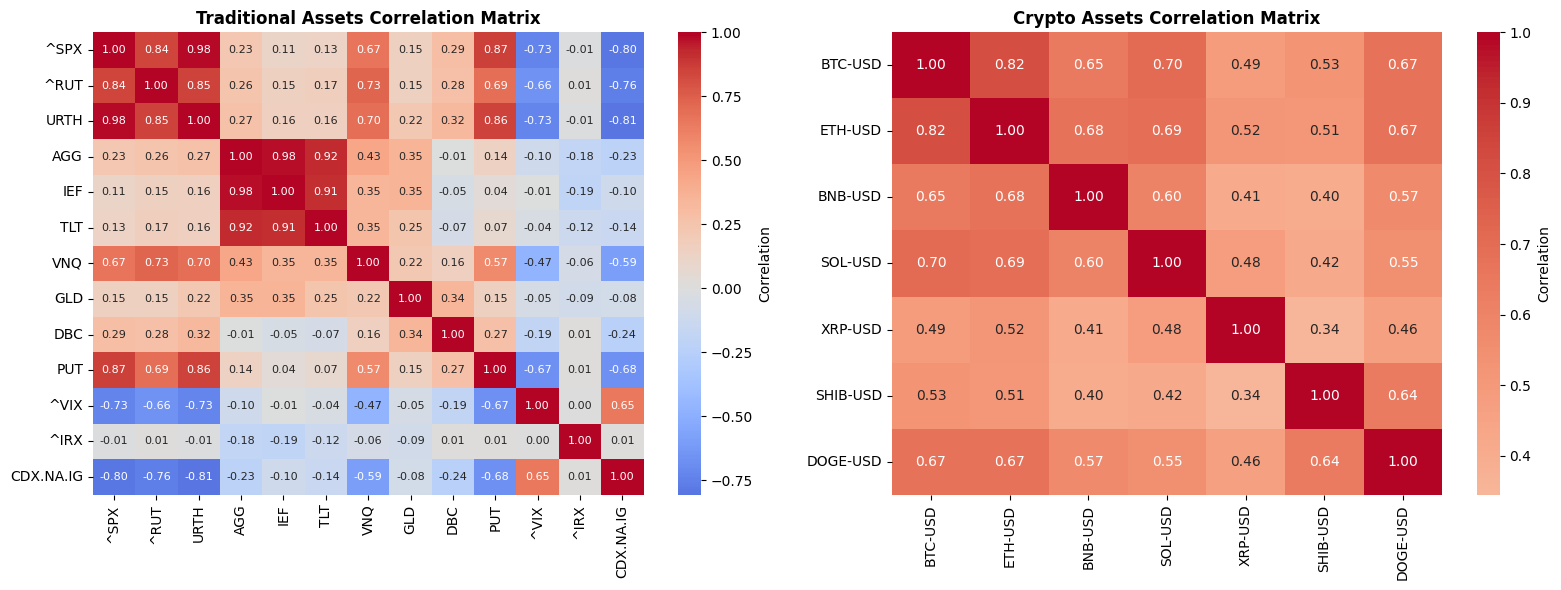

In [5]:
# Correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Traditional correlation
trad_corr = excess_returns_trad.corr()
sns.heatmap(trad_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=axes[0], cbar_kws={'label': 'Correlation'}, annot_kws={'size': 8})
axes[0].set_title('Traditional Assets Correlation Matrix', fontsize=12, fontweight='bold')

# Crypto correlation
crypto_corr = excess_returns_crypto.corr()
sns.heatmap(crypto_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=axes[1], cbar_kws={'label': 'Correlation'}, annot_kws={'size': 10})
axes[1].set_title('Crypto Assets Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'correlation_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()


## 3. MVO Portfolios (Tangency)


In [6]:
# Traditional MVO (Tangency) Portfolio
print("=" * 80)
print("TRADITIONAL MVO (TANGENCY) PORTFOLIO")
print("=" * 80)

# Calculate tangency weights
trad_mvo_weights = pmh.calc_tangency_weights(
    excess_returns_trad,
    annual_factor=ANNUAL_FACTOR,
    name='Trad MVO'
)
print("\nTangency Weights:")
print(trad_mvo_weights.sort_values('Trad MVO Weights', ascending=False))

# Calculate portfolio returns
trad_mvo_returns = pmh.calc_tangency_weights(
    excess_returns_trad,
    annual_factor=ANNUAL_FACTOR,
    name='Trad MVO',
    return_port_ret=True
)
print(f"\nPortfolio returns shape: {trad_mvo_returns.shape}")


TRADITIONAL MVO (TANGENCY) PORTFOLIO

Tangency Weights:
           Trad MVO Weights
AGG                  2.1214
URTH                 1.2961
GLD                  0.6908
^IRX                 0.2823
^SPX                 0.2413
^VIX                 0.0995
CDX.NA.IG            0.0583
TLT                  0.0157
^RUT                -0.1064
PUT                 -0.3088
VNQ                 -0.3160
DBC                 -0.5283
IEF                 -2.5458

Portfolio returns shape: (817, 1)


In [7]:
# Crypto MVO (Tangency) Portfolio
print("=" * 80)
print("CRYPTO MVO (TANGENCY) PORTFOLIO")
print("=" * 80)

# Calculate tangency weights
crypto_mvo_weights = pmh.calc_tangency_weights(
    excess_returns_crypto,
    annual_factor=ANNUAL_FACTOR,
    name='Crypto MVO'
)
print("\nTangency Weights:")
print(crypto_mvo_weights.sort_values('Crypto MVO Weights', ascending=False))

# Calculate portfolio returns
crypto_mvo_returns = pmh.calc_tangency_weights(
    excess_returns_crypto,
    annual_factor=ANNUAL_FACTOR,
    name='Crypto MVO',
    return_port_ret=True
)
print(f"\nPortfolio returns shape: {crypto_mvo_returns.shape}")


CRYPTO MVO (TANGENCY) PORTFOLIO

Tangency Weights:
          Crypto MVO Weights
BTC-USD               1.0632
BNB-USD               0.3734
XRP-USD               0.3074
SOL-USD               0.0970
DOGE-USD              0.0259
SHIB-USD             -0.1094
ETH-USD              -0.7575

Portfolio returns shape: (817, 1)


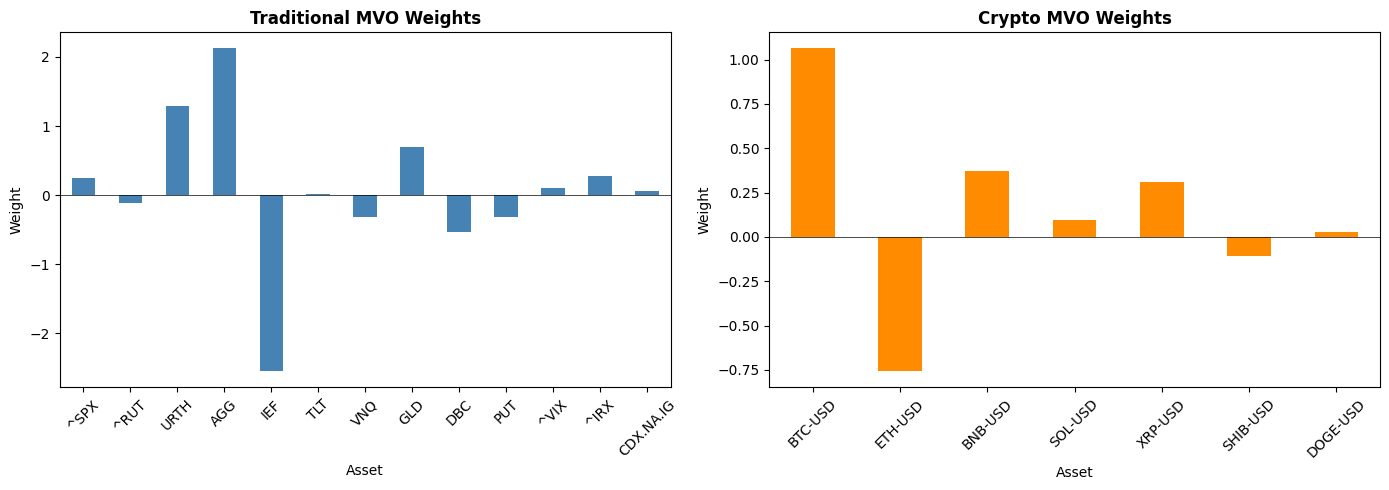

In [8]:
# Visualize MVO weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Traditional MVO weights
trad_mvo_weights.plot(kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Traditional MVO Weights', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Asset')
axes[0].set_ylabel('Weight')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].tick_params(axis='x', rotation=45)

# Crypto MVO weights
crypto_mvo_weights.plot(kind='bar', ax=axes[1], legend=False, color='darkorange')
axes[1].set_title('Crypto MVO Weights', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Asset')
axes[1].set_ylabel('Weight')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'mvo_weights.png'), dpi=300, bbox_inches='tight')
plt.show()


## 4. Risk Parity Portfolios


In [9]:
# Traditional Risk Parity Portfolio
print("=" * 80)
print("TRADITIONAL RISK PARITY PORTFOLIO")
print("=" * 80)

# Calculate risk parity weights
trad_rp_weights = pmh.calc_risk_parity_weights(
    excess_returns_trad,
    name='Trad RP'
)

# Normalize weights to sum to 1
trad_rp_weights_normalized = trad_rp_weights / trad_rp_weights.sum()
print("\nRisk Parity Weights (normalized):")
print(trad_rp_weights_normalized.sort_values('Trad RP Weights', ascending=False))

# Calculate portfolio returns using normalized weights
trad_rp_returns = (excess_returns_trad * trad_rp_weights_normalized['Trad RP Weights'].values).sum(axis=1)
trad_rp_returns = trad_rp_returns.to_frame('Trad RP Portfolio')
print(f"\nPortfolio returns shape: {trad_rp_returns.shape}")


TRADITIONAL RISK PARITY PORTFOLIO

Risk Parity Weights (normalized):
           Trad RP Weights
AGG                 0.3093
IEF                 0.2004
PUT                 0.1117
^IRX                0.0626
URTH                0.0523
GLD                 0.0500
DBC                 0.0494
TLT                 0.0485
^SPX                0.0472
VNQ                 0.0345
^RUT                0.0263
CDX.NA.IG           0.0070
^VIX                0.0008

Portfolio returns shape: (817, 1)


In [10]:
# Crypto Risk Parity Portfolio
print("=" * 80)
print("CRYPTO RISK PARITY PORTFOLIO")
print("=" * 80)

# Calculate risk parity weights
crypto_rp_weights = pmh.calc_risk_parity_weights(
    excess_returns_crypto,
    name='Crypto RP'
)

# Normalize weights to sum to 1
crypto_rp_weights_normalized = crypto_rp_weights / crypto_rp_weights.sum()
print("\nRisk Parity Weights (normalized):")
print(crypto_rp_weights_normalized.sort_values('Crypto RP Weights', ascending=False))

# Calculate portfolio returns using normalized weights
crypto_rp_returns = (excess_returns_crypto * crypto_rp_weights_normalized['Crypto RP Weights'].values).sum(axis=1)
crypto_rp_returns = crypto_rp_returns.to_frame('Crypto RP Portfolio')
print(f"\nPortfolio returns shape: {crypto_rp_returns.shape}")


CRYPTO RISK PARITY PORTFOLIO

Risk Parity Weights (normalized):
          Crypto RP Weights
BTC-USD              0.2882
BNB-USD              0.2378
ETH-USD              0.1664
XRP-USD              0.0908
SOL-USD              0.0839
DOGE-USD             0.0730
SHIB-USD             0.0599

Portfolio returns shape: (817, 1)


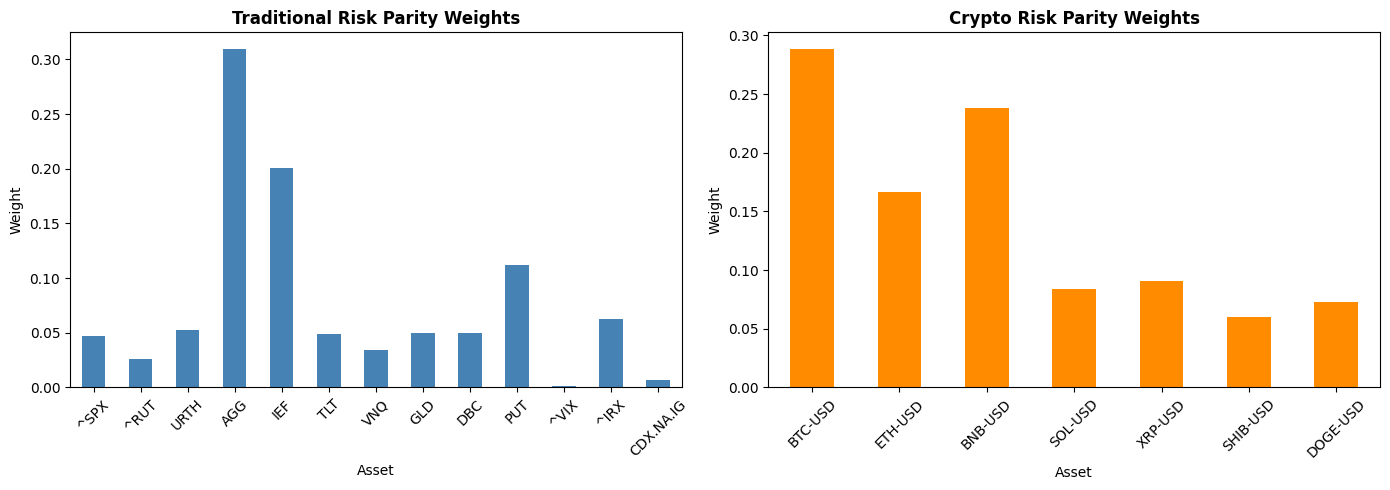

In [11]:
# Visualize Risk Parity weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Traditional RP weights
trad_rp_weights_normalized.plot(kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Traditional Risk Parity Weights', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Asset')
axes[0].set_ylabel('Weight')
axes[0].tick_params(axis='x', rotation=45)

# Crypto RP weights
crypto_rp_weights_normalized.plot(kind='bar', ax=axes[1], legend=False, color='darkorange')
axes[1].set_title('Crypto Risk Parity Weights', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Asset')
axes[1].set_ylabel('Weight')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'rp_weights.png'), dpi=300, bbox_inches='tight')
plt.show()


## 5. CVaR Optimization


In [12]:
def cvar_optimization(returns, alpha=0.05, target_return=None):
    """
    CVaR-constrained portfolio optimization.
    
    Minimizes CVaR (Conditional Value at Risk) at the given confidence level.
    
    Parameters:
    -----------
    returns : pd.DataFrame
        Asset returns (excess returns)
    alpha : float
        Confidence level for CVaR (default 0.05 = 95% CVaR)
    target_return : float or None
        If specified, adds a constraint for minimum expected return
    
    Returns:
    --------
    pd.Series : Optimal portfolio weights
    """
    n_assets = returns.shape[1]
    T = returns.shape[0]
    returns_matrix = returns.values
    mu = returns.mean().values
    
    # Decision variables
    w = cp.Variable(n_assets)  # Portfolio weights
    z = cp.Variable(T)          # Auxiliary variables for CVaR
    gamma = cp.Variable()       # VaR threshold
    
    # Portfolio returns for each period
    portfolio_returns = returns_matrix @ w
    
    # CVaR formulation
    # CVaR = gamma + (1/alpha) * E[max(-r_p - gamma, 0)]
    constraints = [
        cp.sum(w) == 1,      # Weights sum to 1
        w >= 0,               # Long-only constraint
        z >= 0,               # Auxiliary variables non-negative
        z >= -portfolio_returns - gamma  # CVaR linearization
    ]
    
    # Add target return constraint if specified
    if target_return is not None:
        constraints.append(mu @ w >= target_return)
    
    # CVaR objective
    cvar = gamma + (1.0 / (alpha * T)) * cp.sum(z)
    
    # Minimize CVaR
    objective = cp.Minimize(cvar)
    
    problem = cp.Problem(objective, constraints)
    
    try:
        problem.solve(solver=cp.ECOS, verbose=False)
        
        if problem.status in ['optimal', 'optimal_inaccurate']:
            weights = pd.Series(np.maximum(w.value, 0), index=returns.columns)
            weights = weights / weights.sum()  # Normalize
            return weights
    except Exception as e:
        print(f"Optimization failed: {e}")
    
    # Fallback to equal weights
    print("Falling back to equal weights")
    return pd.Series(np.ones(n_assets) / n_assets, index=returns.columns)

print("CVaR optimization function defined.")


CVaR optimization function defined.


In [13]:
# Traditional CVaR Portfolio
print("=" * 80)
print("TRADITIONAL CVaR PORTFOLIO")
print("=" * 80)

# Calculate CVaR-optimal weights
trad_cvar_weights_series = cvar_optimization(excess_returns_trad, alpha=0.05)
trad_cvar_weights = trad_cvar_weights_series.to_frame('Trad CVaR Weights')

print("\nCVaR-Optimal Weights:")
print(trad_cvar_weights.sort_values('Trad CVaR Weights', ascending=False))

# Calculate portfolio returns
trad_cvar_returns = (excess_returns_trad * trad_cvar_weights_series.values).sum(axis=1)
trad_cvar_returns = trad_cvar_returns.to_frame('Trad CVaR Portfolio')
print(f"\nPortfolio returns shape: {trad_cvar_returns.shape}")


TRADITIONAL CVaR PORTFOLIO
Optimization failed: The solver ECOS is not installed.
Falling back to equal weights

CVaR-Optimal Weights:
           Trad CVaR Weights
^SPX                  0.0769
^RUT                  0.0769
URTH                  0.0769
AGG                   0.0769
IEF                   0.0769
TLT                   0.0769
VNQ                   0.0769
GLD                   0.0769
DBC                   0.0769
PUT                   0.0769
^VIX                  0.0769
^IRX                  0.0769
CDX.NA.IG             0.0769

Portfolio returns shape: (817, 1)


In [14]:
# Crypto CVaR Portfolio
print("=" * 80)
print("CRYPTO CVaR PORTFOLIO")
print("=" * 80)

# Calculate CVaR-optimal weights
crypto_cvar_weights_series = cvar_optimization(excess_returns_crypto, alpha=0.05)
crypto_cvar_weights = crypto_cvar_weights_series.to_frame('Crypto CVaR Weights')

print("\nCVaR-Optimal Weights:")
print(crypto_cvar_weights.sort_values('Crypto CVaR Weights', ascending=False))

# Calculate portfolio returns
crypto_cvar_returns = (excess_returns_crypto * crypto_cvar_weights_series.values).sum(axis=1)
crypto_cvar_returns = crypto_cvar_returns.to_frame('Crypto CVaR Portfolio')
print(f"\nPortfolio returns shape: {crypto_cvar_returns.shape}")


CRYPTO CVaR PORTFOLIO
Optimization failed: The solver ECOS is not installed.
Falling back to equal weights

CVaR-Optimal Weights:
          Crypto CVaR Weights
BTC-USD                0.1429
ETH-USD                0.1429
BNB-USD                0.1429
SOL-USD                0.1429
XRP-USD                0.1429
SHIB-USD               0.1429
DOGE-USD               0.1429

Portfolio returns shape: (817, 1)


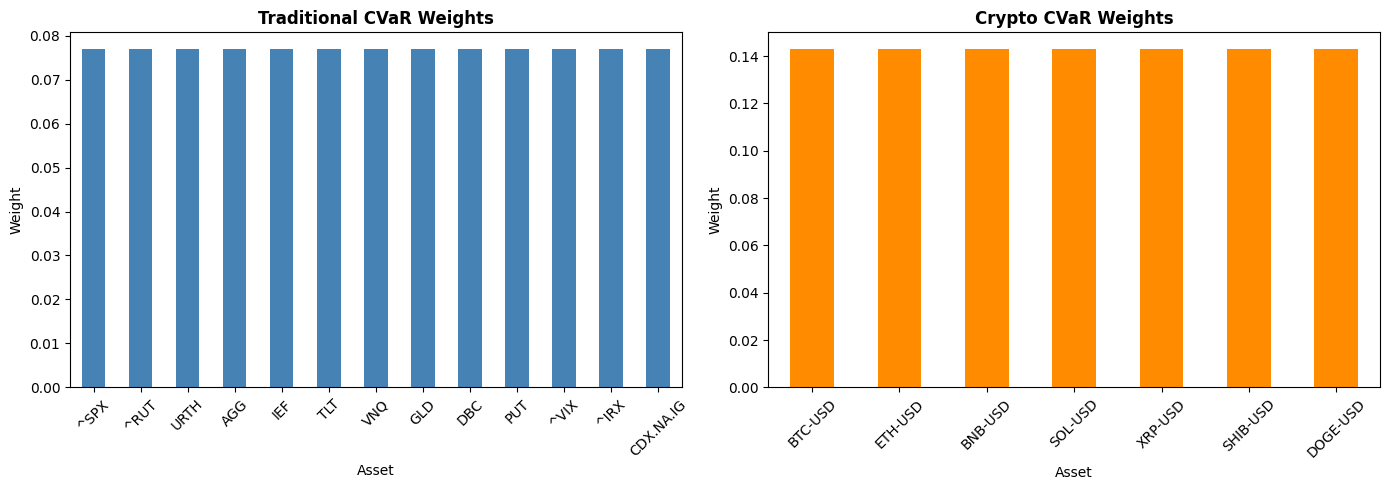

In [15]:
# Visualize CVaR weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Traditional CVaR weights
trad_cvar_weights.plot(kind='bar', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Traditional CVaR Weights', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Asset')
axes[0].set_ylabel('Weight')
axes[0].tick_params(axis='x', rotation=45)

# Crypto CVaR weights
crypto_cvar_weights.plot(kind='bar', ax=axes[1], legend=False, color='darkorange')
axes[1].set_title('Crypto CVaR Weights', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Asset')
axes[1].set_ylabel('Weight')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'cvar_weights.png'), dpi=300, bbox_inches='tight')
plt.show()


## 6. Performance Comparison


In [16]:
# Combine all portfolio returns
# Align all returns to common date range
all_portfolios = pd.concat([
    trad_mvo_returns,
    crypto_mvo_returns,
    trad_rp_returns,
    crypto_rp_returns,
    trad_cvar_returns,
    crypto_cvar_returns
], axis=1)

# Rename columns for clarity
all_portfolios.columns = [
    'Trad MVO', 'Crypto MVO',
    'Trad RP', 'Crypto RP',
    'Trad CVaR', 'Crypto CVaR'
]

all_portfolios = all_portfolios.dropna()
print(f"Combined portfolios shape: {all_portfolios.shape}")
print(f"Date range: {all_portfolios.index[0].date()} to {all_portfolios.index[-1].date()}")


Combined portfolios shape: (817, 6)
Date range: 2022-08-01 to 2025-10-30


In [17]:
# Calculate comprehensive performance metrics for all portfolios
print("=" * 80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 80)

performance_stats = pmh.calc_summary_statistics(
    all_portfolios,
    annual_factor=ANNUAL_FACTOR,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False,
    keep_columns=[
        'Annualized Mean', 'Annualized Vol', 'Annualized Sharpe',
        'Max Drawdown', 'Skewness', 'Excess Kurtosis',
        'Historical VaR (5.00%)', 'Historical CVaR (5.00%)'
    ]
)

# Sort by Sharpe ratio
performance_stats_sorted = performance_stats.sort_values('Annualized Sharpe', ascending=False)
print(performance_stats_sorted)

# Save to CSV
performance_stats_sorted.to_csv(os.path.join(TABLE_DIR, 'portfolio_performance_comparison.csv'))
print(f"\nSaved to {os.path.join(TABLE_DIR, 'portfolio_performance_comparison.csv')}")


COMPREHENSIVE PERFORMANCE COMPARISON
             Annualized Mean  Annualized Vol  Annualized Sharpe  Skewness  \
Trad MVO              0.4790          0.1650             2.9030    0.4164   
Crypto MVO            0.7808          0.5381             1.4510    0.5269   
Crypto RP             0.5665          0.5438             1.0417    0.1773   
Crypto CVaR           0.6068          0.6205             0.9779    0.5509   
Trad CVaR             0.0760          0.0886             0.8580    1.5228   
Trad RP               0.0170          0.0653             0.2609    0.5045   

             Excess Kurtosis  Max Drawdown  
Trad MVO              2.5966       -0.0884  
Crypto MVO            4.9077       -0.3109  
Crypto RP             4.1651       -0.4185  
Crypto CVaR           6.0382       -0.4905  
Trad CVaR            10.0339       -0.0595  
Trad RP               4.3386       -0.0776  

Saved to outputs/tables/portfolio_performance_comparison.csv


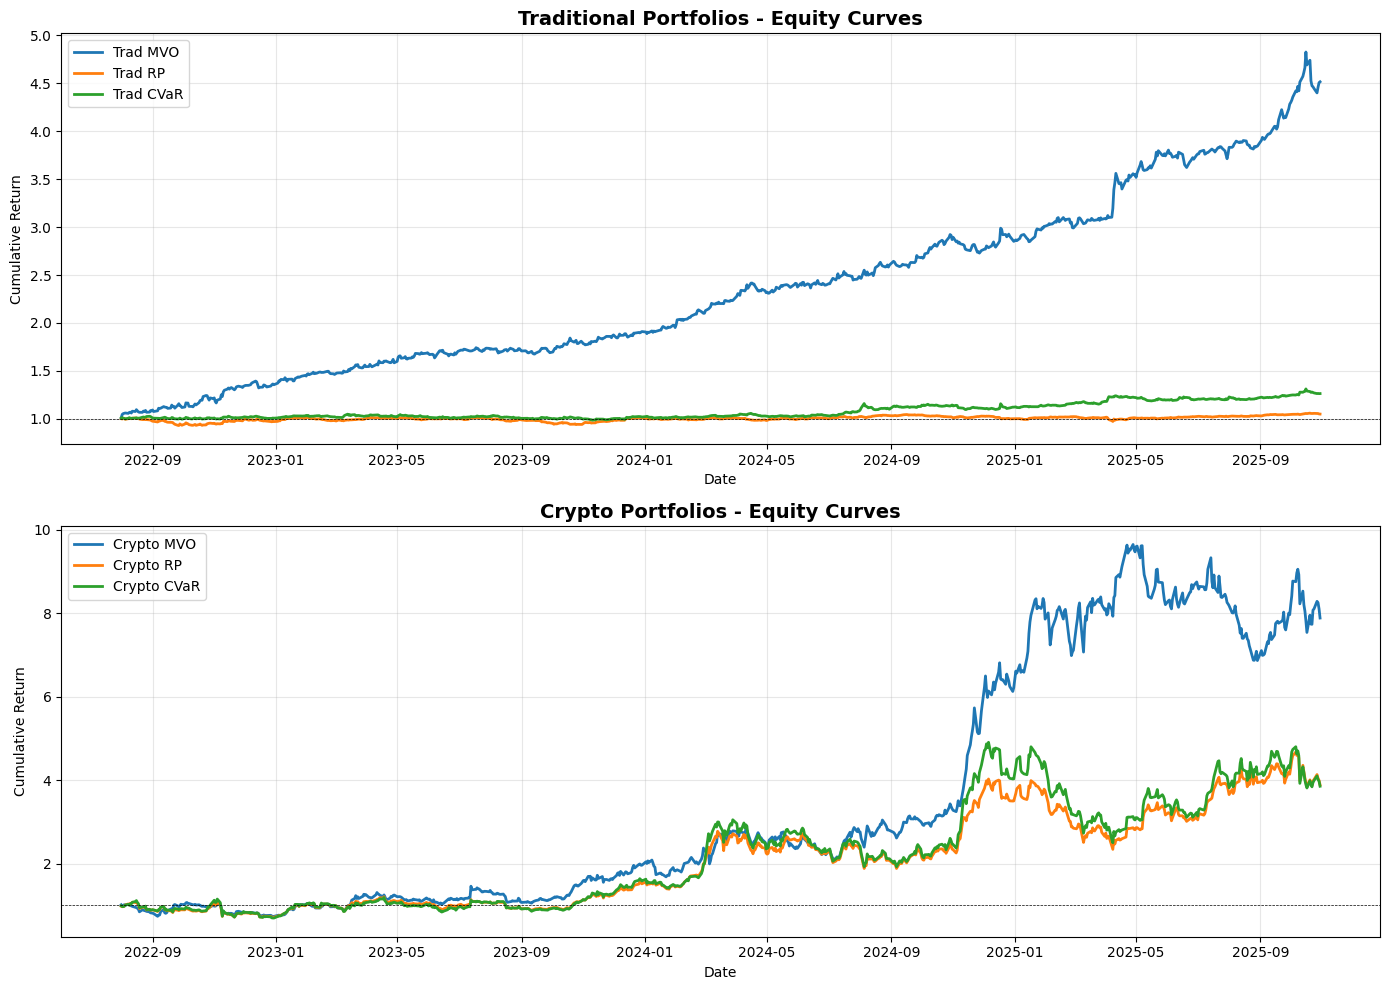

In [18]:
# Equity curves
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns
cumulative_returns = (1 + all_portfolios).cumprod()

# Traditional portfolios
trad_cols = ['Trad MVO', 'Trad RP', 'Trad CVaR']
for col in trad_cols:
    axes[0].plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=2)
axes[0].set_title('Traditional Portfolios - Equity Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Return')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1, color='black', linestyle='--', linewidth=0.5)

# Crypto portfolios
crypto_cols = ['Crypto MVO', 'Crypto RP', 'Crypto CVaR']
for col in crypto_cols:
    axes[1].plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=2)
axes[1].set_title('Crypto Portfolios - Equity Curves', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'equity_curves.png'), dpi=300, bbox_inches='tight')
plt.show()


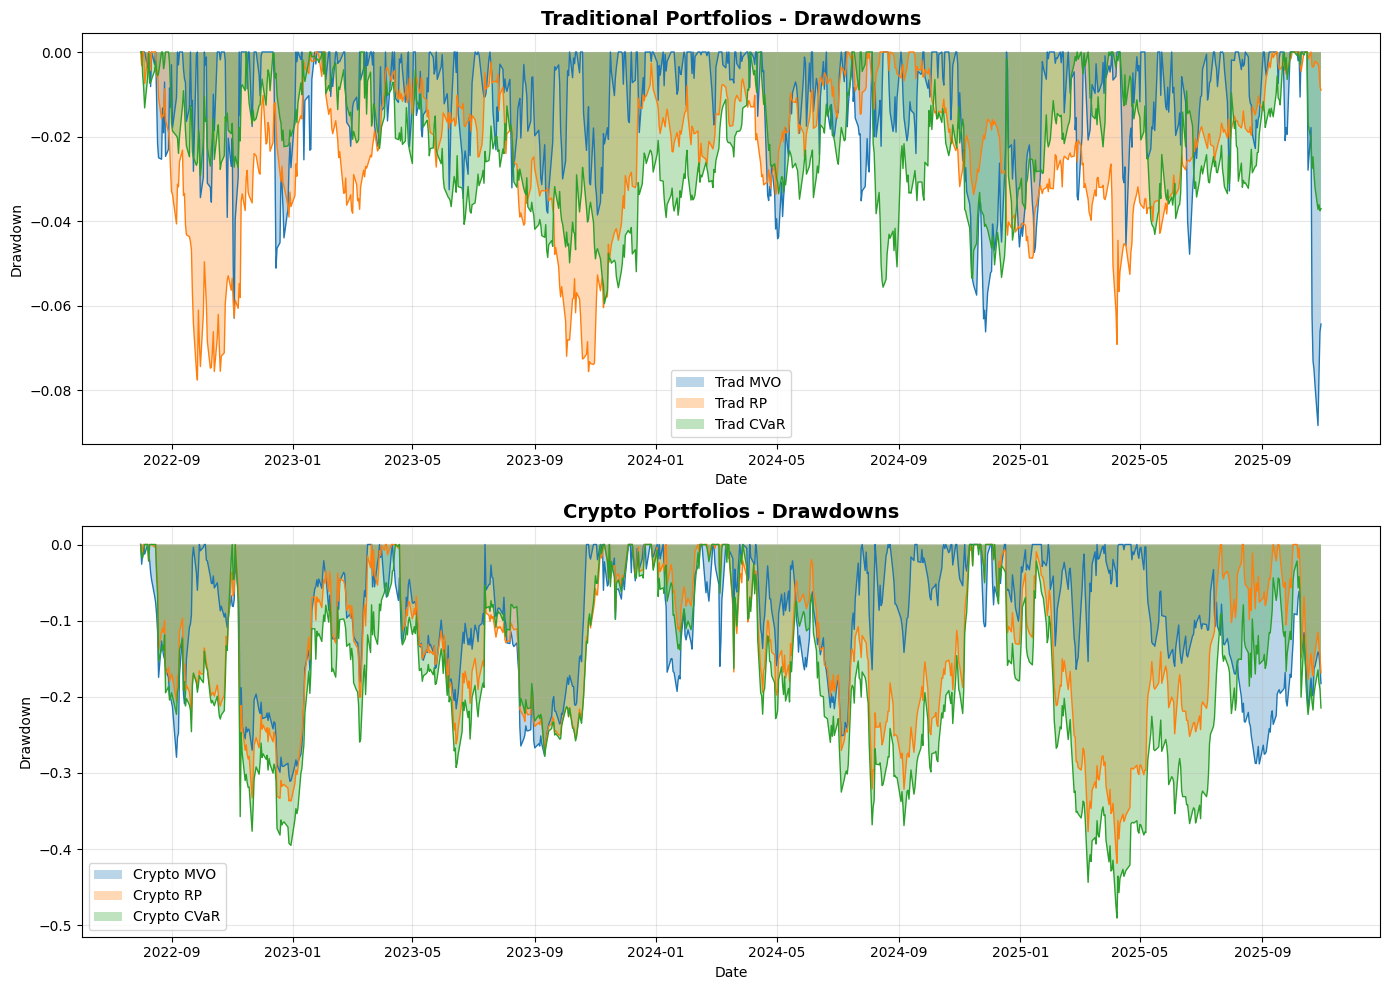

In [19]:
# Drawdowns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

def calc_drawdowns(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown

drawdowns = all_portfolios.apply(calc_drawdowns)

# Traditional portfolios drawdowns
for col in trad_cols:
    axes[0].fill_between(drawdowns.index, drawdowns[col], 0, alpha=0.3, label=col)
    axes[0].plot(drawdowns.index, drawdowns[col], linewidth=1)
axes[0].set_title('Traditional Portfolios - Drawdowns', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Drawdown')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Crypto portfolios drawdowns
for col in crypto_cols:
    axes[1].fill_between(drawdowns.index, drawdowns[col], 0, alpha=0.3, label=col)
    axes[1].plot(drawdowns.index, drawdowns[col], linewidth=1)
axes[1].set_title('Crypto Portfolios - Drawdowns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'drawdowns.png'), dpi=300, bbox_inches='tight')
plt.show()


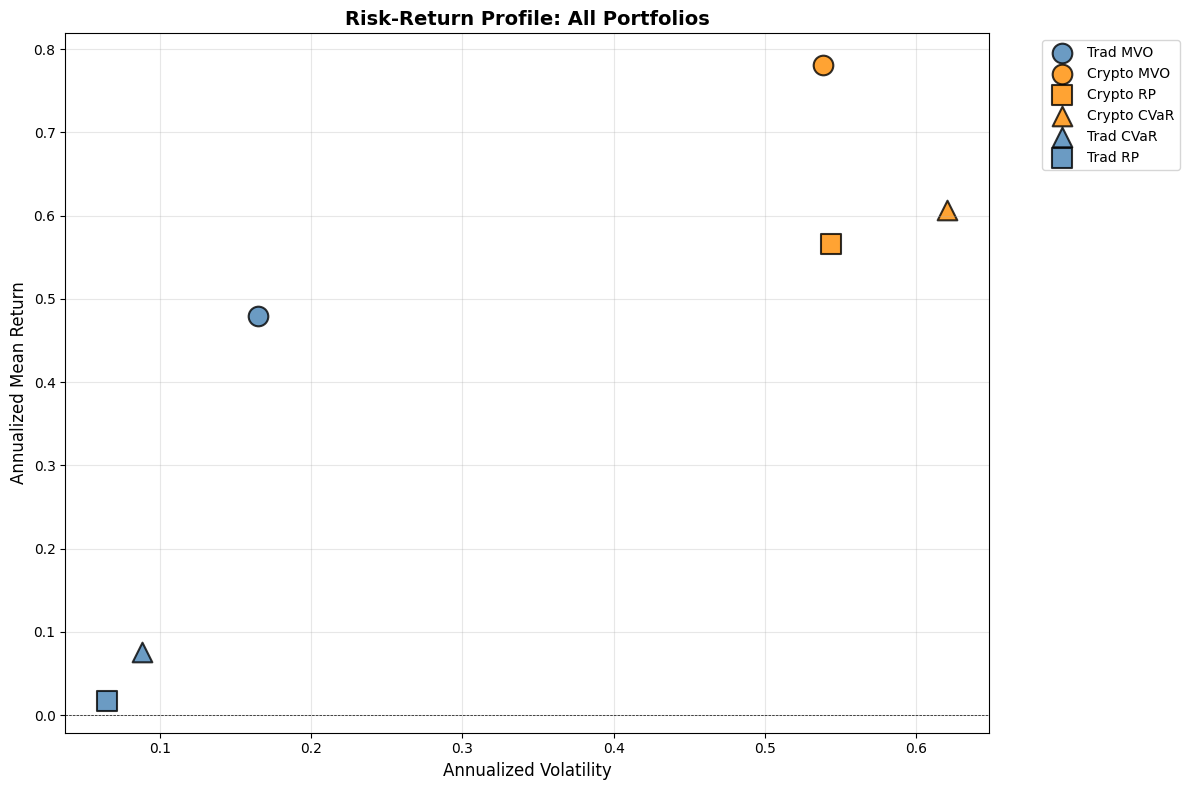

In [20]:
# Risk-Return Scatter Plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'Trad': 'steelblue', 'Crypto': 'darkorange'}
markers = {'MVO': 'o', 'RP': 's', 'CVaR': '^'}

for portfolio in performance_stats_sorted.index:
    asset_type = 'Trad' if 'Trad' in portfolio else 'Crypto'
    method = 'MVO' if 'MVO' in portfolio else ('RP' if 'RP' in portfolio else 'CVaR')
    
    ax.scatter(
        performance_stats_sorted.loc[portfolio, 'Annualized Vol'],
        performance_stats_sorted.loc[portfolio, 'Annualized Mean'],
        c=colors[asset_type],
        marker=markers[method],
        s=200,
        alpha=0.8,
        edgecolors='black',
        linewidth=1.5,
        label=portfolio
    )

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Annualized Mean Return', fontsize=12)
ax.set_title('Risk-Return Profile: All Portfolios', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'risk_return_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()


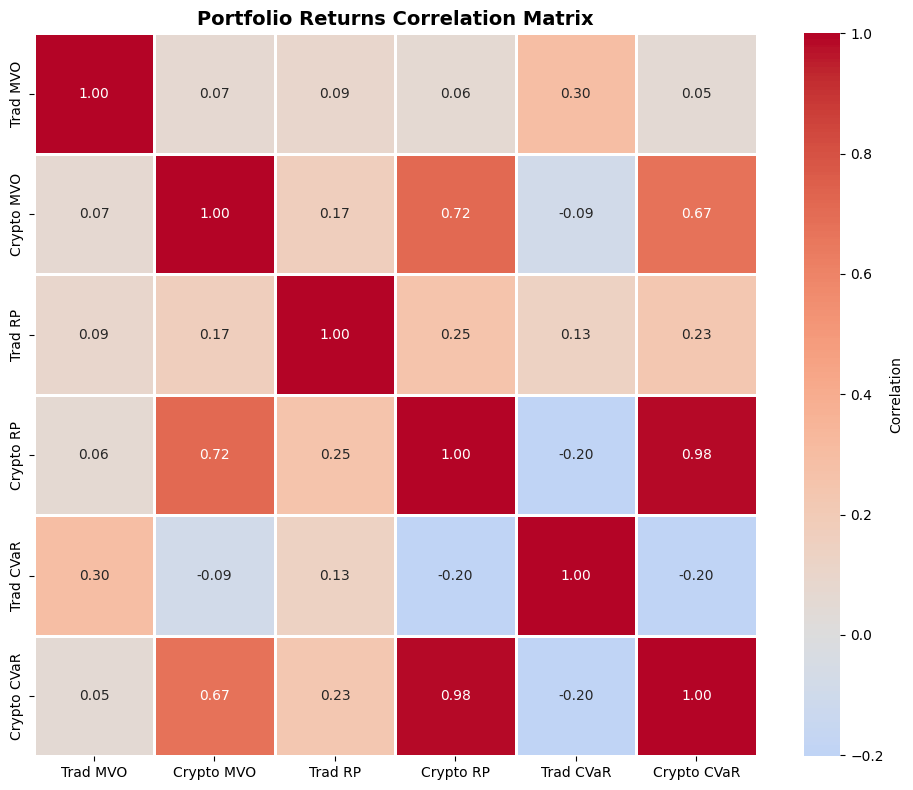

In [21]:
# Portfolio Returns Correlation Matrix
fig, ax = plt.subplots(figsize=(10, 8))

portfolio_corr = all_portfolios.corr()
sns.heatmap(portfolio_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Portfolio Returns Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'portfolio_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# Save all weights to CSV
all_weights = pd.concat([
    trad_mvo_weights.rename(columns={'Trad MVO Weights': 'Trad MVO'}),
    trad_rp_weights_normalized.rename(columns={'Trad RP Weights': 'Trad RP'}),
    trad_cvar_weights.rename(columns={'Trad CVaR Weights': 'Trad CVaR'}),
], axis=1)
all_weights.to_csv(os.path.join(TABLE_DIR, 'traditional_portfolio_weights.csv'))

crypto_all_weights = pd.concat([
    crypto_mvo_weights.rename(columns={'Crypto MVO Weights': 'Crypto MVO'}),
    crypto_rp_weights_normalized.rename(columns={'Crypto RP Weights': 'Crypto RP'}),
    crypto_cvar_weights.rename(columns={'Crypto CVaR Weights': 'Crypto CVaR'}),
], axis=1)
crypto_all_weights.to_csv(os.path.join(TABLE_DIR, 'crypto_portfolio_weights.csv'))

print("Traditional Portfolio Weights:")
print(all_weights)
print("\nCrypto Portfolio Weights:")
print(crypto_all_weights)


Traditional Portfolio Weights:
           Trad MVO  Trad RP  Trad CVaR
^SPX         0.2413   0.0472     0.0769
^RUT        -0.1064   0.0263     0.0769
URTH         1.2961   0.0523     0.0769
AGG          2.1214   0.3093     0.0769
IEF         -2.5458   0.2004     0.0769
TLT          0.0157   0.0485     0.0769
VNQ         -0.3160   0.0345     0.0769
GLD          0.6908   0.0500     0.0769
DBC         -0.5283   0.0494     0.0769
PUT         -0.3088   0.1117     0.0769
^VIX         0.0995   0.0008     0.0769
^IRX         0.2823   0.0626     0.0769
CDX.NA.IG    0.0583   0.0070     0.0769

Crypto Portfolio Weights:
          Crypto MVO  Crypto RP  Crypto CVaR
BTC-USD       1.0632     0.2882       0.1429
ETH-USD      -0.7575     0.1664       0.1429
BNB-USD       0.3734     0.2378       0.1429
SOL-USD       0.0970     0.0839       0.1429
XRP-USD       0.3074     0.0908       0.1429
SHIB-USD     -0.1094     0.0599       0.1429
DOGE-USD      0.0259     0.0730       0.1429


In [23]:
# Save portfolio returns
all_portfolios.to_csv(os.path.join(TABLE_DIR, 'portfolio_returns.csv'))
print(f"Portfolio returns saved to {os.path.join(TABLE_DIR, 'portfolio_returns.csv')}")


Portfolio returns saved to outputs/tables/portfolio_returns.csv


## 7. Summary & Key Findings


In [24]:
print("=" * 80)
print("SUMMARY & KEY FINDINGS")
print("=" * 80)

# Best performers by metric
print("\n### Best Performers by Metric:")
print(f"  Highest Sharpe: {performance_stats_sorted['Annualized Sharpe'].idxmax()} ({performance_stats_sorted['Annualized Sharpe'].max():.4f})")
print(f"  Highest Return: {performance_stats_sorted['Annualized Mean'].idxmax()} ({performance_stats_sorted['Annualized Mean'].max():.2%})")
print(f"  Lowest Volatility: {performance_stats_sorted['Annualized Vol'].idxmin()} ({performance_stats_sorted['Annualized Vol'].min():.2%})")
print(f"  Smallest Max DD: {performance_stats_sorted['Max Drawdown'].idxmax()} ({performance_stats_sorted['Max Drawdown'].max():.2%})")

# Check for CVaR column - it might have different naming
cvar_cols = [col for col in performance_stats_sorted.columns if 'CVaR' in col and '5' in col]
if cvar_cols:
    cvar_col = cvar_cols[0]
    print(f"  Best CVaR (5%): {performance_stats_sorted[cvar_col].idxmax()} ({performance_stats_sorted[cvar_col].max():.4f})")

# Traditional vs Crypto comparison
print("\n### Traditional vs Crypto Comparison:")
trad_portfolios = [p for p in performance_stats_sorted.index if 'Trad' in p]
crypto_portfolios = [p for p in performance_stats_sorted.index if 'Crypto' in p]

avg_trad = performance_stats_sorted.loc[trad_portfolios].mean()
avg_crypto = performance_stats_sorted.loc[crypto_portfolios].mean()

comparison = pd.DataFrame({
    'Traditional (Avg)': avg_trad,
    'Crypto (Avg)': avg_crypto
})
print(comparison)

# Method comparison within each universe
print("\n### Best Method by Universe:")
best_trad = performance_stats_sorted.loc[trad_portfolios, 'Annualized Sharpe'].idxmax()
best_crypto = performance_stats_sorted.loc[crypto_portfolios, 'Annualized Sharpe'].idxmax()
print(f"  Best Traditional: {best_trad} (Sharpe: {performance_stats_sorted.loc[best_trad, 'Annualized Sharpe']:.4f})")
print(f"  Best Crypto: {best_crypto} (Sharpe: {performance_stats_sorted.loc[best_crypto, 'Annualized Sharpe']:.4f})")


SUMMARY & KEY FINDINGS

### Best Performers by Metric:
  Highest Sharpe: Trad MVO (2.9030)
  Highest Return: Crypto MVO (78.08%)
  Lowest Volatility: Trad RP (6.53%)
  Smallest Max DD: Trad CVaR (-5.95%)

### Traditional vs Crypto Comparison:
                   Traditional (Avg)  Crypto (Avg)
Annualized Mean               0.1907        0.6513
Annualized Vol                0.1063        0.5675
Annualized Sharpe             1.3406        1.1569
Skewness                      0.8146        0.4184
Excess Kurtosis               5.6564        5.0370
Max Drawdown                 -0.0752       -0.4066

### Best Method by Universe:
  Best Traditional: Trad MVO (Sharpe: 2.9030)
  Best Crypto: Crypto MVO (Sharpe: 1.4510)


In [25]:
# Statistical significance test between best traditional and best crypto
print("\n### Statistical Significance Test")
print(f"Comparing: {best_trad} vs {best_crypto}")

# Align returns for comparison
aligned_returns = all_portfolios[[best_trad, best_crypto]].dropna()

# Paired t-test
t_stat, p_value = stats.ttest_ind(
    aligned_returns[best_trad],
    aligned_returns[best_crypto]
)

print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at 5% level: {'Yes' if p_value < 0.05 else 'No'}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print(f"All results saved to: {OUT_DIR}/")
print("=" * 80)



### Statistical Significance Test
Comparing: Trad MVO vs Crypto MVO
  t-statistic: -0.9656
  p-value: 0.3344
  Significant at 5% level: No

ANALYSIS COMPLETE
All results saved to: outputs/
